In [1]:
#!pip3 install tqdm
#!pip3 install ipywidgets

In [2]:
#from ipywidgets import IProgress
#!pip install tqdm

use terminal - ```igwn-keras2```

In [3]:


import scipy.io
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [4]:
mat = scipy.io.loadmat('gravity_spy/Blip_strain.mat')
#mat = scipy.io.loadmat('gravity_spy/Repeating_Blips_strain.mat')


mat["outData"].shape
n = len(mat["outData"][:,0])

In [5]:
n

1024

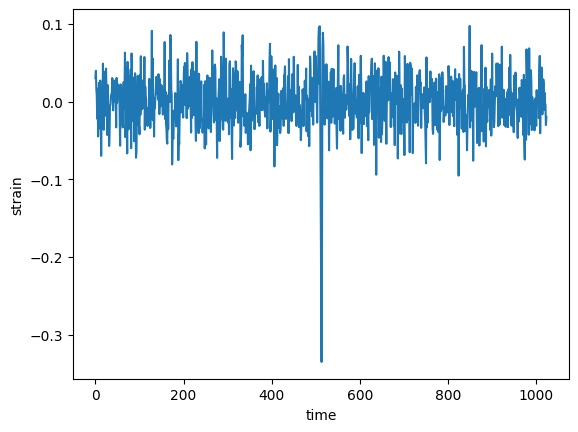

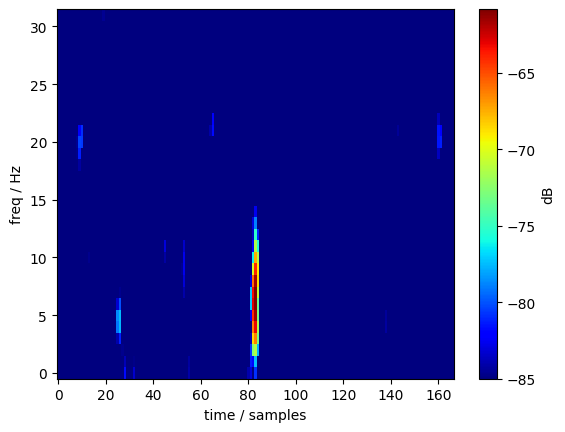

In [18]:
#BETTER SHORT TIME FOURIER TRANSFORM
wave_number = 4
fft_size = 32
overlap_fac = 0.8
# data = a numpy array containing the signal to be processed
data   =  mat["outData"][:,wave_number] 

plt.plot(data)
plt.ylabel("strain")
plt.xlabel("time")
plt.figure()


# fs = a scalar which is the sampling frequency of the data
fs = 1024
 
hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
t_max = len(data) / np.float32(fs)
 
window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size
 
proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result
 
for i in range(total_segments):                      # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
    autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
    result[i, :] = autopower[:fft_size]               # append to the results array

result = 20*np.log10(result)          # scale to db
result = np.clip(result,-85, -40)[:-(int(fft_size*0.15)),:].T   # clip values, and remove edge effects


img = plt.imshow(result, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.ylabel("freq / Hz")
plt.xlabel("time / samples")

plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful

plt.show()

In [7]:
#BETTER SHORT TIME FOURIER TRANSFORM
def better_stft(data, fs = 1024, fft_size = 32, overlap_fac = 0.8):

    # fs = a scalar which is the sampling frequency of the data
    #fft_size = the size of the fast fourier transform window [power of 2]
    #overlap_fac = the overlap factor [0-1]


    hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
    pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
    t_max = len(data) / np.float32(fs)

    window = np.hanning(fft_size)  # our half cosine window
    inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

    proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
    result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

    for i in range(total_segments):                      # for each segment
        current_hop = hop_size * i                        # figure out the current segment offset
        segment = proc[current_hop:current_hop+fft_size]  # get the current segment
        windowed = segment * window                       # multiply by the half cosine function
        padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
        spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
        autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
        result[i, :] = autopower[:fft_size]               # append to the results array

    #result = 20*np.log10(result)          # scale to db
    #result = np.clip(result,-85, -40)[:-(int(fft_size*0.15)),:].T   # clip values, and remove edge effects
    
    result = result[:-(int(fft_size*0.15)),:].T
    return result



1024
255


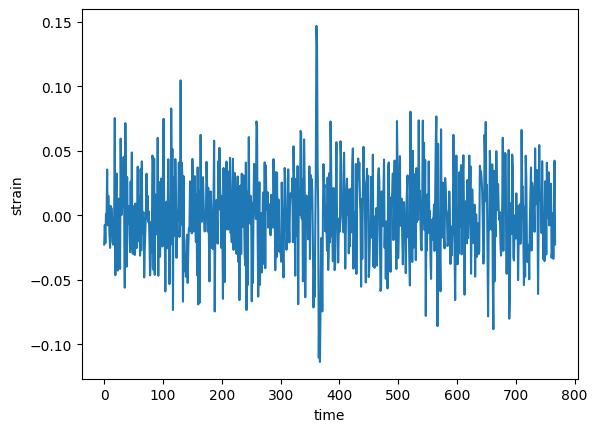

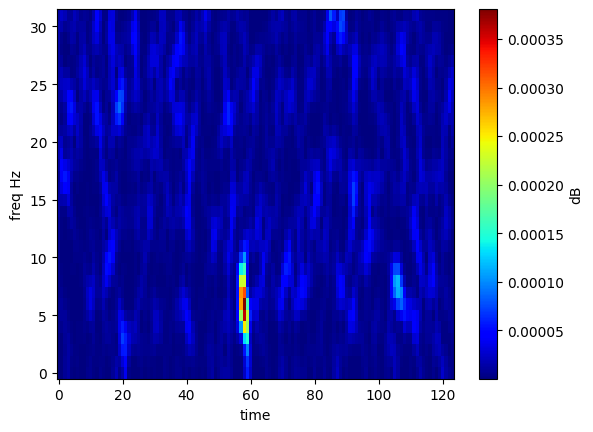

(32, 124)

In [21]:
wave_number = 3
# data = a numpy array containing the signal to be processed
print(n)
print( (int(n/4)-1) )
random_offset = np.random.randint(0, high = (int(n/4)-1) ) #-1 is for security to prevent calling out of bounds
    
data = mat["outData"][:,wave_number][random_offset:random_offset+int((3*n)/4)]

plt.plot(data)
plt.ylabel("strain")
plt.xlabel("time")
plt.figure()

result = better_stft(data)
img = plt.imshow(result, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.ylabel("freq Hz")
plt.xlabel("time")

plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful

plt.show()

result.shape


In [9]:
img_shape = result.shape
img_size = img_shape[0]*img_shape[1]
print(img_shape)
print(img_size)

(32, 124)
3968


In [10]:
test_train_ratio = 0.8

x_train = np.zeros([int(mat["outData"].shape[1]*test_train_ratio), result.shape[0]*result.shape[1]])
x_test = np.zeros([int(mat["outData"].shape[1]*(1-test_train_ratio))-1, result.shape[0]*result.shape[1]])

print(f'{x_train.shape} {x_test.shape}')

(830, 3968) (206, 3968)


In [11]:
for i in np.arange(len(x_train)):
    random_offset = np.random.randint(0, high = (int(n/4)-1) ) #-1 is for security to prevent calling out of bounds
    #random_offset = (int(n/8)-1)
    
    wave_ = mat["outData"][:,i][random_offset:random_offset+int((3*n)/4)]
    
    x_train[i] = better_stft(wave_).reshape((3968,))

In [12]:
for i in np.arange(len(x_test)):
    random_offset = np.random.randint(0, high = (int(n/4)-1) ) #-1 is for security to prevent calling out of bounds
    #random_offset = (int(n/8)-1)
    
    wave_ = mat["outData"][:,i+len(x_train)][random_offset:random_offset+int((3*n)/4)]
    
    x_test[i] = better_stft(wave_).reshape((3968,))

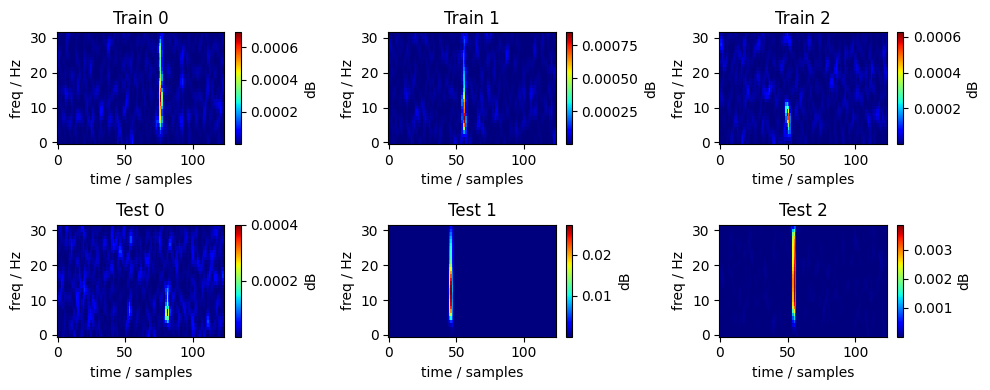

In [19]:
n_ = 3  # How many digits we will display

plt.figure(figsize=(10, 4))
for i in range(n_):
    # Display original
    ax = plt.subplot(2, n_, i + 1)
    
    img = plt.imshow(x_train[i].reshape(img_shape), origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
    plt.ylabel("freq / Hz")
    plt.xlabel("time / samples")
    plt.title(f"Train {i}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n_, i + 1 + n_)
    
    img = plt.imshow(x_test[i].reshape(img_shape), origin='lower',interpolation='nearest', cmap='jet',  aspect='auto')
    plt.ylabel("freq / Hz")
    plt.xlabel("time / samples")
    plt.title(f"Test {i}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()

Check that these first 10 train and test images are different ^^

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
"""
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(img_size))  #1024 make it this! #####################################
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(img_size, activation='sigmoid')(encoded)  #1024 make it this!####################

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
"""

2022-12-05 19:56:00.366550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


'\n# This is the size of our encoded representations\nencoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats\n\n# This is our input image\ninput_img = keras.Input(shape=(img_size))  #1024 make it this! #####################################\n# "encoded" is the encoded representation of the input\nencoded = layers.Dense(encoding_dim, activation=\'relu\')(input_img)\n# "decoded" is the lossy reconstruction of the input\ndecoded = layers.Dense(img_size, activation=\'sigmoid\')(encoded)  #1024 make it this!####################\n\n# This model maps an input to its reconstruction\nautoencoder = keras.Model(input_img, decoded)\n'

In [15]:
# This is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
#input_img = keras.Input(shape=(img_shape))  #1024 make it this! #####################################
# "encoded" is the encoded representation of the input
#encoded = layers.Conv2D(encoding_dim, 16, input_shape=(img_shape))(input_img)
# "decoded" is the lossy reconstruction of the input
#decoded = layers.Conv2D(img_size, 16, activation='sigmoid')(encoded)  #1024 make it this!####################

  #1024 make it this!####################

img_shape_ = [img_shape[0], img_shape[1], 3]

inputs = keras.Input(shape = ())
conv1 = layers.Conv2D(32, kernel_size = (5,5), strides = (1,1), activation = 'relu')(inputs)
max1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)
conv2 = layers.Conv2D(64, (5,5), activation = 'relu')(max1)
max2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
flat = layers.Flatten()(max2)
den1 = layers.Dense(100, activation = 'relu')(flat)
decoded = layers.Dense(img_size, activation='sigmoid')(den1)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=1. Full shape received: (None,)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

try using convolutional layers here ########################################

In [ ]:
x_train[0]

In [ ]:
print(max(x_train.flatten()) - min(x_train.flatten()))
print(min(x_train.flatten()))

plt.hist(x_train.flatten(), bins=30)
plt.yscale('log')
plt.show()


In [ ]:
### NORMALISATION ###
"""
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
"""

"""
normaliserm = max(x_train.flatten()) - min(x_train.flatten())
normaliserc = min(x_train.flatten())
x_train = (x_train-normaliserc) / normaliserm
x_test = (x_test-normaliserc) / normaliserm
"""

"""
normaliserm = np.amax(x_train, axis=0) - np.amin(x_train, axis=0)
normaliserc = np.amin(x_train, axis=0)
x_train = (x_train-normaliserc) / normaliserm
x_test = (x_test-normaliserc) / normaliserm
"""

normaliserm = 0.004

normaliserc = 0
x_train = (x_train-normaliserc) / normaliserm
x_test = (x_test-normaliserc) / normaliserm


print(x_train.shape)
print(x_test.shape)

x_train = x_train.reshape(-1, img_shape[0], img_shape[1], 1)
x_test = x_test.reshape(-1, img_shape[0], img_shape[1], 1)

print(x_train.shape)
print(x_test.shape)

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs=100, #50
                batch_size=256, #256
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

In [ ]:
n_ = 3 # How many digits we will display
offset = 0

plt.figure(figsize=(10, 6))
for i in range(n_):
    # Display original
    ax = plt.subplot(3, n_, i + 1)
    
    img = plt.imshow(x_test[i+offset].reshape(img_shape), origin='lower', cmap='jet', interpolation='nearest', aspect='auto', vmin = 0, vmax = 1)
    plt.ylabel("freq Hz")
    plt.xlabel("time")
    plt.title(f"Test {i+offset}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    

    # Display reconstruction
    ax = plt.subplot(3, n_, i + 1 + n_)
    
    img = plt.imshow(decoded_imgs[i+offset].reshape(img_shape), origin='lower',interpolation='nearest', cmap='jet',  aspect='auto', vmin = 0, vmax = 1)
    plt.ylabel("freq Hz")
    plt.xlabel("time")
    plt.title(f"Reconstruction {i+offset}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    
    # Display Diff
    ax = plt.subplot(3, n_, i + 1 + 2*n_)
    
    img = plt.imshow((x_test[i+offset]-decoded_imgs[i+offset]).reshape(img_shape), origin='lower',interpolation='nearest', cmap='jet',  aspect='auto', vmin = 0, vmax = 1)
    plt.ylabel("freq Hz")
    plt.xlabel("time")
    plt.title(f"Difference {i+offset}")

    plt.colorbar(label="dB") #is dB correct here?? I'm not sure but its useful
    plt.tight_layout()
    

plt.show()

add all signals and should get a number thats even if noise, kai squared distribution statistically 

In [ ]:
sum_diff = np.zeros_like(decoded_imgs[:,1])

for i, decoded in enumerate(decoded_imgs):
    sum_diff[i] = np.sum(x_test[i]-decoded_imgs[i])

sum_diff.shape
np.savetxt(f"m_moving{normaliserm}.txt", sum_diff)

The better the performance, we should see the sum differnce near zero

In [ ]:
plt.boxplot(sum_diff)
plt.show()

In [ ]:
data_moving = np.loadtxt("m_moving0.004.txt")
data_4 = np.loadtxt("m_0.004.txt")
data_3 = np.loadtxt("m_0.003.txt")
data_7 = np.loadtxt("m_0.007.txt")
data_6 = np.loadtxt("m_0.006.txt")
data_2 = np.loadtxt("m_0.002.txt")
data_1 = np.loadtxt("m_0.001.txt")

plt.boxplot([data_4,data_moving], labels=["still","moving"])
plt.axhline(0)
#plt.ylim(-80,80)

plt.show()